### Player group (team) clusterization

In [1]:
import os
import random
from time import time
from shutil import copy2
from collections import Counter

import numpy as np
import pandas as pd
import cv2
from cv2 import compareHist
from scipy.spatial.distance import (
    cosine, euclidean,
    braycurtis, canberra, chebyshev, correlation, dice, hamming, jaccard,
    kulsinski, mahalanobis, matching, minkowski, rogerstanimoto, russellrao, 
    seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule
)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import pairwise_distances
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# whether to use Embeddings or Histograms as image feature-vectors
use_embeddings = False

In [3]:
# load image feature-vectors dataset
if use_embeddings:
    x_data = "X_df_embed"
    y_data = "y_df_embed"
else:
    x_data = "X_df"
    y_data = "y_df"
X_df = pd.read_pickle(x_data)
y_df = pd.read_pickle(y_data)

X_12 = X_df[y_df.isin([1,2])]
y_12 = list(y_df[y_df.isin([1,2])])
Xy_12_df = X_12.copy()
Xy_12_df['target'] = y_12
Counter(y_df), Counter(y_12)

(Counter({0: 74, 1: 740, 2: 740}), Counter({1: 740, 2: 740}))

### TSNE

In [4]:
def draw_tsne(X_12, y_12, perplexity, n_components):
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0, perplexity=perplexity)
    t0 = time()
    X_tsne = tsne.fit_transform(X_12)

    print('Samples in each team', X_12.shape[0] // 2, ', perplexity', perplexity)
    color_dict = {1: 'red', 2: 'yellow', 0: 'black'}
    colors = [color_dict[label] for label in y_12]
    plt.scatter([x[0] for x in X_tsne], [x[1] for x  in X_tsne], color=colors)
    return X_tsne

Samples in each team 100 , perplexity 5


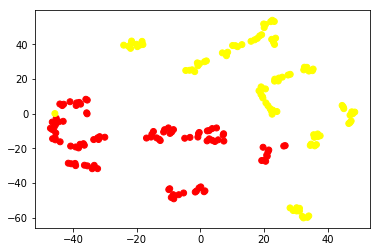

In [5]:
X_tsne_15 = draw_tsne(X_12[0:200], y_12[:200], 5, 2)

Samples in each team 105 , perplexity 10


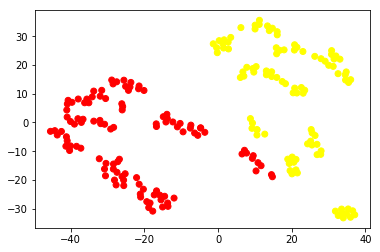

In [6]:
X_tsne_10 = draw_tsne(X_12[0:210], y_12[:210], 10, 2)

In [7]:
X_12.shape, len(y_12)

((1480, 512), 1480)

### PCA

Text(0.5,1,'PCA 1st and 3rd components')

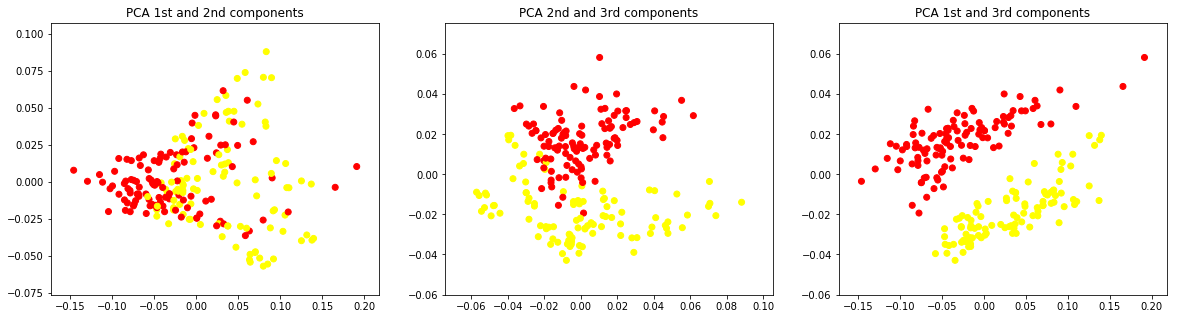

In [8]:
color_dict = {1: 'red', 2: 'yellow', 0: 'black', 3: 'orange', 4:'green'}
colors = [color_dict[x] for x in y_12[:210]]
pca = PCA(n_components=5)
pca = pca.fit_transform(X_12[:210])
fig = plt.figure(figsize=(20,5))
a=fig.add_subplot(1, 3, 1)
a.scatter([x[0] for x in pca], [x[1] for x  in pca], color=colors)
a.set_title('PCA 1st and 2nd components')
a=fig.add_subplot(1, 3, 2)
a.scatter([x[1] for x in pca], [x[2] for x  in pca], color=colors)
a.set_title('PCA 2nd and 3rd components')
a=fig.add_subplot(1, 3, 3)
a.scatter([x[0] for x in pca], [x[2] for x in pca], color=colors)
a.set_title('PCA 1st and 3rd components')

## Clusterization

!["cluster-comparison"](extras/cluster_comparison_shadow.png)

### Clusterization - KMeans

In [9]:
def clusterization(model, group_size, number_of_images=1000):
    '''
    Cuts feature dataset on groups of size 'group_size', and performs clusterization for each group.  
    '''
    for i in range(0, number_of_images, 2*group_size):
        model = model.fit(X_12[i: i + 2*group_size])
        labels = model.labels_
        evaluate(Xy_12_df[i: i + 2*group_size], labels)
        print('===========================================================')

def print_clusters(person_type, labels):
    if not len(labels):
        return
    print(person_type, len(labels), 'images:')
    counts = Counter(labels)
    print('>>  ' + '; '.join(["cluster_" + str(k) + ": " + str(counts[k]) for k in counts]))
    print('-----------------------------------')

def evaluate(df, labels):
    '''
    Compares clusterization labels with true labels. 
    '''
    labels0 = labels[df['target']==0]
    print_clusters('Referee:', labels0)
    labels1 = labels[df['target']==1]
    print_clusters('Team1 -', labels1)
    labels2 = labels[df['target']==2]
    print_clusters('Team2 -', labels2)

In [10]:
kmeans = KMeans(max_iter = 100, n_clusters=2, random_state=0).fit(X_12[:200])

In [11]:
clusterization(kmeans, group_size=10, number_of_images=100)

Team1 - 10 images:
>>  cluster_1: 8; cluster_0: 2
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 6; cluster_1: 4
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 3; cluster_1: 7
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 7; cluster_1: 3
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 2; cluster_1: 8
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 6; cluster_1: 4
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 3; cluster_1: 7
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 7; cluster_1: 3
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 4; cluster_1: 6
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 10
-----------------------------------


In [12]:
clusterization(kmeans, group_size=100, number_of_images=1000)

Team1 - 100 images:
>>  cluster_0: 22; cluster_1: 78
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 58; cluster_1: 42
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 76; cluster_0: 24
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 62; cluster_1: 38
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 81; cluster_0: 19
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 58; cluster_1: 42
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 73; cluster_1: 27
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 95; cluster_1: 5
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 80; cluster_1: 20
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 85; cluster_1: 15
-----------------------------------


### Clusterization - DBScan

In [13]:
eps = 0.1
dbscan = DBSCAN(eps=eps, metric=cosine, algorithm='brute', n_jobs=4)
print('results for epsilon {}\n'.format(eps))
clusterization(dbscan, group_size=10, number_of_images=100)

results for epsilon 0.1

Team1 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team1 - 10 images:
>>  cluster_0: 10
-----------------------------------
Team2 - 10 images:
>>  cluster_0: 10
-----------------------------------


In [14]:
clusterization(dbscan, group_size=100, number_of_images=1000)

Team1 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------


### Clusterization - Agglomerative

![](extras/Hierarchical-Clustering-Dendrogram.png)

[Histogram Comparison in OpenCV](https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html)

#### Hellinger distance (Bhattacharyya distance)

![HELLINGER](extras/metrics_hellinger.png)
where

H1 – 1st compared histogram,

H2 – 2nd compared histogram of the same size as H1,

N – total number of histogram bins.




In [15]:
metric_hellinger = lambda x, y: compareHist(x.astype(np.float32), y.astype(np.float32), cv2.HISTCMP_HELLINGER)
affinity = lambda x, m=metric_hellinger: pairwise_distances(x, metric=m)

In [16]:
print('with *scikit*')
print('Metric HELLINGER')
if use_embeddings:
    affinity = 'cosine'
agglo = AgglomerativeClustering(n_clusters=2, affinity=affinity, memory=None, linkage='average')
clusterization(agglo, 100, 1000)

with *scikit*
Metric HELLINGER
Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 80; cluster_1: 20
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 80; cluster_1: 20
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 100
-----------------------------------


In [17]:
default_metric = metric_hellinger
default_metric_name = 'HELLINGER'
if use_embeddings:
    default_metric = 'cosine'
    default_metric_name = 'COSINE'

In [18]:
print('With *scipy*')
print(f'Metric {default_metric_name}')
group_size = 100
number_of_images = 1000
print('Team size: ', group_size, '\n')
for i in range(0, number_of_images, 2*group_size):
    y = pdist(X_12[i: i + 2*group_size], default_metric)
    linkage_matrix = linkage(y, method='average', optimal_ordering=True)
    dd = dendrogram(linkage_matrix, no_plot=True)
    labels = [1] * group_size + [2] * group_size
    idx = dd['leaves']
    idx_df = pd.Series(labels, index=idx).sort_index()
    evaluate(Xy_12_df[i: i + 2*group_size], idx_df.values)
    print('============================================================================================')

With *scipy*
Metric HELLINGER
Team size:  100 

Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_2: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_2: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_2: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 100
-----------------------------------
Team2 - 100 images:
>>  cluster_2: 100
-----------------------------------
Team1 - 100 images:
>>  cluster_1: 88; cluster_2: 12
-----------------------------------
Team2 - 100 images:
>>  cluster_2: 88; cluster_1: 12
-----------------------------------


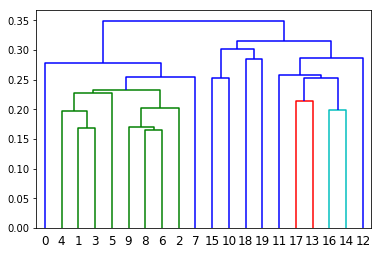

In [19]:
y = pdist(X_12[120: 140], default_metric)
linkage_matrix = linkage(y, method='average', optimal_ordering=True)
dd = dendrogram(linkage_matrix, no_plot=False)

### Clusterization - Spectral

In [20]:
spectral = SpectralClustering(n_clusters=2, n_init=100, affinity=default_metric, n_neighbors=10, n_jobs=4)
clusterization(spectral, 100, 1000)

Team1 - 100 images:
>>  cluster_0: 99; cluster_1: 1
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 99; cluster_1: 1
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 99; cluster_1: 1
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 99; cluster_1: 1
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 98; cluster_1: 2
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 98; cluster_1: 2
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 97; cluster_1: 3
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 96; cluster_1: 4
-----------------------------------
Team1 - 100 images:
>>  cluster_0: 96; cluster_1: 4
-----------------------------------
Team2 - 100 images:
>>  cluster_0: 96; cluster_1: 4
-----------------------------------


### Referee and Team identification

In [21]:
def agglomerative_clustering(vectors, metric):
    '''
    Applies Agglomerative clustering to identify teams.
    '''
    linkage_matrix = linkage(vectors, method="average", metric=metric, optimal_ordering=True)
    return dendrogram(linkage_matrix, no_plot=True)["leaves"]

def find_outlier(X, metric):
    '''
    Applies Outlier model to identify referee.
    '''
    referee_classifier = LocalOutlierFactor(n_neighbors=3, contamination=0.04, metric=metric)
    preds = referee_classifier.fit_predict(X)
    return preds.argmin()

def cluster(X, y, group_size, outlier_metric, team_metric):
    '''
    Clusters X feature dataset on 2 teams and referee. Returns whether referee and teams were indetified. 
    '''
    team_1_features = X[y == 1]
    team_2_features = X[y == 2]
    referee_features = X[y == 0]
    team_1_true_ids = np.array(range(group_size))[y == 1]
    team_2_true_ids = np.array(range(group_size))[y == 2]
    referee_true_id = np.array(range(group_size))[y == 0][0]

    referee_predicted_id = find_outlier(X, outlier_metric)
    referee_identified = referee_true_id == referee_predicted_id
    
    team_1_true_ids[team_1_true_ids > referee_true_id] -= 1
    team_2_true_ids[team_2_true_ids > referee_true_id] -= 1    
    features = np.concatenate([team_1_features, team_2_features])
    idx = agglomerative_clustering(features, team_metric)
    team_1_predicted_ids = idx[: (group_size - 1) // 2]
    team_2_predicted_ids = idx[(group_size - 1) // 2:]
    team_clusters_case_1 = (set(team_1_predicted_ids) == set(team_1_true_ids)) and (
        set(team_2_predicted_ids) == set(team_2_true_ids))
    team_clusters_case_2 = (set(team_1_predicted_ids) == set(team_2_true_ids)) and (
        set(team_2_predicted_ids) == set(team_1_true_ids))
    return referee_identified, team_clusters_case_1 or team_clusters_case_2

In [22]:
def indentify_people(metrics):
    '''
    Evaluates accuracy of the team and referee clusterization.
    '''
    group_size = 21
    clusterization_results = []
    for i in range(0, len(X_df), group_size):
        X, y = X_df[i: i + group_size], y_df[i: i + group_size]
        clusterization_results.append(cluster(X, y, group_size, **metrics))

    print(f"Referee identified: {sum([x[0] for x in clusterization_results])} out of {len(clusterization_results)}")
    print(f"2 teams clustered: {sum([x[1] for x in clusterization_results])} out of {len(clusterization_results)}")

#### canberra distance
![](extras/canberra.png)
where

u - 1st histogram,

v - 2nd histogram.

In [23]:
metrics = {'outlier_metric': canberra, 'team_metric': canberra}
indentify_people(metrics)

Referee identified: 0 out of 74
2 teams clustered: 42 out of 74


In [24]:
metrics = {'outlier_metric': cosine, 'team_metric': cosine}
indentify_people(metrics)

Referee identified: 19 out of 74
2 teams clustered: 6 out of 74


In [25]:
metrics = {'outlier_metric': default_metric, 'team_metric': default_metric}
indentify_people(metrics)

Referee identified: 20 out of 74
2 teams clustered: 62 out of 74
